In [10]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pvtrace.scene.scene import Scene
from pvtrace.scene.renderer import MeshcatRenderer
from pvtrace.scene.node import Node
from pvtrace.algorithm import photon_tracer
from pvtrace.geometry.sphere import Sphere
from pvtrace.material.dielectric import Dielectric, LossyDielectric
from pvtrace.material.lumophore import Lumophore
from pvtrace.material.host import Host
from pvtrace.light.ray import Ray
import logging
logging.getLogger("pvtrace").setLevel(logging.CRITICAL)

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


# Material types
In this notebook we will continue with the same example in quick start 1 but investigate different material types.

Let's define the original scene.

In [11]:
world = Node(
    name="world (air)",
    geometry=Sphere(
        radius=10.0,
        material=Dielectric.air()
    )
)
sphere = Node(
    name="sphere (glass)",
    geometry=Sphere(
        radius=1.0,
        material=Dielectric.glass()
    ),
    parent=world
)
ray = Ray(
    position=(-1.0, 0.0, 0.9),
    direction=(1.0, 0.0, 0.0),
    wavelength=600.0
)
scene = Scene(world)

## Dielectric material

In pvtrace a dielectric material is a material type that only has a refractive index attribute; it only interacts with rays by reflection and refraction, calculated by the Fresnel equations. This is useful but slightly limited compared to the other material types available. If you don't need any absorption or emission in your simulations and just want to perform ray optics simulations this is the way to go.

To construct a Dielectric object directly you need to numerical data of refractive index.

    x = np.linspace(400.0, 800.0, 50)
    y = np.ones(50) * 1.5
    refractive_index = np.column_stack((x, y))
    material = Dielectric(refractive_index)

The Dielectric class offers three quick ways to get started.

    wavelength_range = (400.0, 800.0)
    material = Dielectric.make_constant(wavelength_range, 1.6)
   
Makes a dielectric material with constant refractive index of 1.6 over the specified frequency range.

    air = Dielectric.air(x_range=wavelength_range)

Makes a material like air with refractive index of 1.0.

    glass = Dielectric.glass(x_range=wavelength_range)

Makes a material like air with refractive index of 1.5.

The `x_range` argument is optional. If it is no supplied the default range is 300nm to 4000nm.

Let's trace 100 rays into the scene with the sphere of the dielectric material.

In [12]:
vis = MeshcatRenderer()
vis.render(scene)
for _ in range(100):
    steps = photon_tracer.follow(ray, scene)
    path, decisions = zip(*steps)
    vis.add_ray_path(path)
    time.sleep(0.001)  # allow the renderer a chance to redraw
vis.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


## Lossy dielectric material

A lossy dielectric has a refractive index attribute and an absorption coefficient; it refracts, reflects and absorbs rays. When rays are absorbed they are killed and no longer traced.

To construct a LossyDielectric object directly you need to numerical data of refractive index and absorption coefficient. The units of absorption coefficient are in cm$^{-1}$ and internally will be used with the Beer-Lambert law in base *e*: $I(x) = I_o e^{(-\alpha x)}.$

    x = np.linspace(400.0, 800.0, 50)
    ri = np.ones(50) * 1.5
    refractive_index = np.column_stack((x, ri))
    alpha = np.ones(50) * 5.0  # 5cm-1
    absorption_coefficient = np.column_stack((x, alpha))
    material = Dielectric(refractive_index, absorption_coefficient)

To make flat profiles you can use the class method,

    material=LossyDielectric.make_constant((400.0, 800.0), 1.5, 5.0)

which does everything above but in one line.
    
Let's change the material attached to the sphere. Here we make a lossy dielectric with an absorption coefficient and refractive index defined between 300nm to 4000nm. The refractive index is 1.5 and the absorption coefficient is 5cm$^{-1}.$

In [13]:
world = Node(
    name="world (air)",
    geometry=Sphere(
        radius=10.0,
        material=Dielectric.air()
    )
)
sphere = Node(
    name="sphere (glass)",
    geometry=Sphere(
        radius=1.0,
        material=LossyDielectric.make_constant((300, 4000), 1.5, 5.0)
    ),
    parent=world
)
ray = Ray(
    position=(-1.0, 0.0, 0.9),
    direction=(1.0, 0.0, 0.0),
    wavelength=600.0
)
scene = Scene(world)
vis = MeshcatRenderer()
vis.render(scene)
for _ in range(10):
    steps = photon_tracer.follow(ray, scene)
    path, decisions = zip(*steps)
    vis.add_ray_path(path)
    time.sleep(0.001)  # allow the renderer a chance to redraw
vis.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


To see that the ray path length inside the sphere is attenuated, click Open Controls in the meshcat viewer, open the meshcat node, and uncheck "world (air)". Now it is highly unlikely that the ray will travel more than a few millimeters.

## Lumophore material

The lumophore material has absorption coefficient, emission spectrum and quantum yield attributes, but does not have a refractive index attribute,

    x = ... # your wavelength axis
    abs_data = ... # your absorption spectrum in units cm-1
    ems_data = ... # your emission spectrum
    abs_spec = np.column_stack((x, abs_data))
    ems_spec = np.column_stack((x, ems_data))
    qy = 1.0
    lum = Lumophore(abs_spec, ems_spec, qy)

pvtrace comes with a default spectrum of the dye Lumogen F Red,

    x = np.linspace(200, 800, 200)
    alpha = 5.0
    qy = 1.0
    lum = Lumophore.make_lumogen_f_red(x, alpha, qy)


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


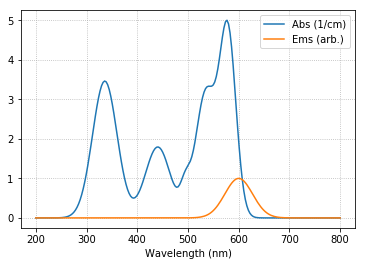

In [14]:
wavelength = np.linspace(200, 800, 200)
lumophore = Lumophore.make_lumogen_f_red(wavelength, 5.0, 1.0)
plt.plot(wavelength, lumophore.absorption_coefficient(wavelength), label="Abs (1/cm)")
plt.plot(wavelength, lumophore.emission_spectrum(wavelength), label="Ems (arb.)")
plt.xlabel("Wavelength (nm)")
plt.legend()
plt.grid(linestyle="dotted")

In [15]:
world = Node(
    name="world (air)",
    geometry=Sphere(
        radius=10.0,
        material=Dielectric.air()
    )
)

# Make the Lumophore material here
wavelength = np.linspace(200, 800, 200)
lumophore = Lumophore.make_lumogen_f_red(wavelength, 5.0, 1.0)

sphere = Node(
    name="sphere (glass)",
    geometry=Sphere(
        radius=1.0,
        material=lumophore  # assign it here
    ),
    parent=world
)
ray = Ray(
    position=(-1.0, 0.0, 0.9),
    direction=(1.0, 0.0, 0.0),
    wavelength=600.0
)
scene = Scene(world)

In [16]:
vis = MeshcatRenderer()
vis.render(scene)
for _ in range(10):
    steps = photon_tracer.follow(ray, scene)
    path, decisions = zip(*steps)
    vis.add_ray_path(path)
    time.sleep(0.001)  # allow the renderer a chance to redraw
vis.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


The orange ray enters the lumophore sphere, some rays can pass directly through, unabsorbed, because the absorption coefficient is faily low compared to the thickness of the sphere. Others are absorbed and re-emitted and longer (reshifted) wavelengths. These are the red rays, which branch from the orange ray path. They are locations where an orange ray has been absorbed and a re-emission event occurs.

Note that the there is no refraction at the interfaces of a lumophore material. As mentioned before, this is because it does not have an refractive index attribute and therefore pvtrace does not apply any refraction at the interfaces.

## Host material

A host material brings all of the above building blocks together and is probably the most interesting material type for users for the software. It has a refractive index and can be initialised with a single or multiple lumophores.

Luminescent solar concentrators and spectral down-shifters are comprised of a lumophores which are typically blended with a polymer host matrix. The host provides the dominant contribution to bulk refractive index. This is reason why lumophore materials in pvtrace do not have a refractive index attribute.

In [17]:
world = Node(
    name="world (air)",
    geometry=Sphere(
        radius=10.0,
        material=Dielectric.air()
    )
)

sphere = Node(
    name="sphere (glass)",
    geometry=Sphere(
        radius=1.0,
        material=Host(
            np.column_stack( # refractive index spectrum
                (wavelength,
                 np.ones(wavelength.size) * 1.5)
            ), 
            [lumophore],  # list of lumophores, reuse the one we already have.
        )
    ),
    parent=world
)
ray = Ray(
    position=(-1.0, 0.0, 0.9),
    direction=(1.0, 0.0, 0.0),
    wavelength=600.0
)
scene = Scene(world)

In [18]:
vis = MeshcatRenderer()
vis.render(scene)
for _ in range(10):
    steps = photon_tracer.follow(ray, scene)
    path, decisions = zip(*steps)
    vis.add_ray_path(path)
    time.sleep(0.001)  # allow the renderer a chance to redraw
vis.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7007/static/


The visualisation shows refraction upon enter or exiting the sphere. Also, the paths now taken are now much more complex because of internal reflection which increases the path length through the lumophore material resulting in more absorption and reemission events.

In the next tutorial we will introduce light sources which makes generating rays that sample a realistic spectrum trivial.